number of kept words=1000 - ratio=94.2358763006284 %


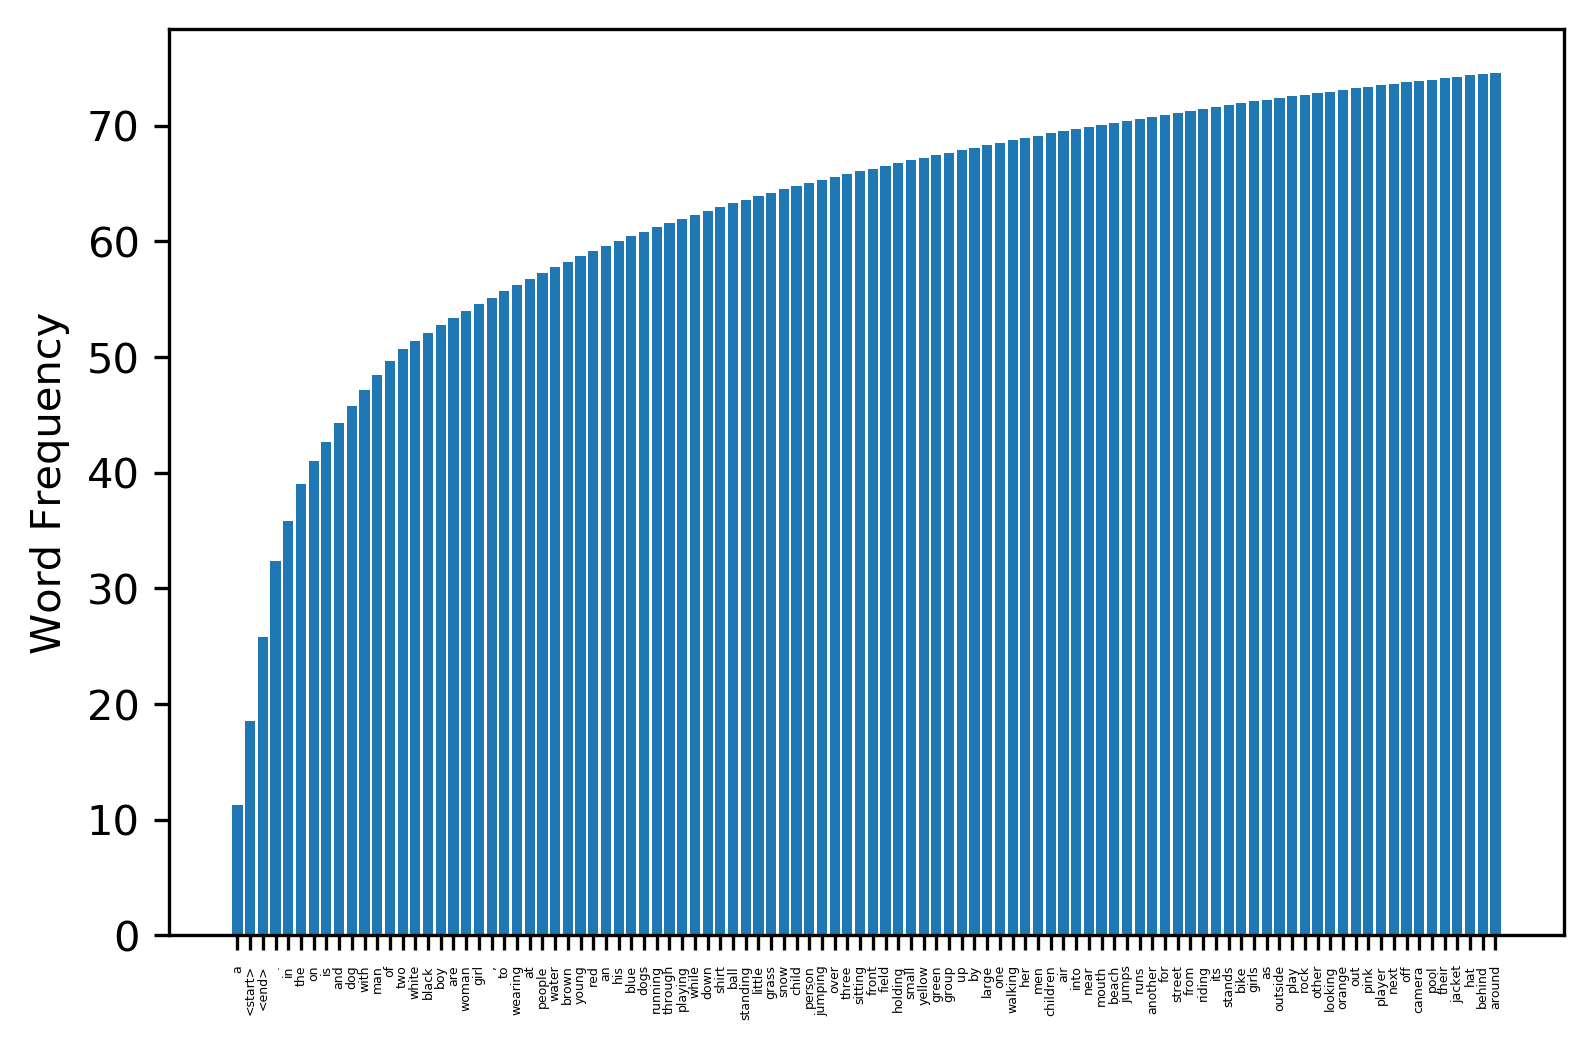

max caption length =35


In [2]:
import pandas as pd
import _pickle as pickle
import matplotlib.pyplot as plt
import numpy as np

filename = 'flickr_8k_train_dataset.txt'
df = pd.read_csv(filename, delimiter='\t')
nb_samples = df.shape[0]
iter = df.iterrows()

bow = {}
nbwords = 0

for i in range(nb_samples):
    x = iter.__next__()
    cap_words = x[1][1].split()  # split caption into words
    cap_wordsl = [w.lower() for w in cap_words]  # remove capital letters
    nbwords += len(cap_wordsl)
    for w in cap_wordsl:
        if (w in bow):
            bow[w] = bow[w] + 1
        else:
            bow[w] = 1

bown = sorted([(value, key) for (key, value) in bow.items()], reverse=True)

nbkeep = 1000 # 100 is needed for fast processing

outfile = 'Caption_Embeddings.p'
[listwords, embeddings] = pickle.load(open(outfile, "rb"))
embeddings_new = np.zeros((nbkeep, 102))
listwords_new = []

for i in range(nbkeep):
    listwords_new.append(bown[i][1])
    embeddings_new[i, :] = embeddings[listwords.index(bown[i][1])] 
    embeddings_new[i, :] /= np.linalg.norm(embeddings_new[i, :])  # Normalization

listwords = listwords_new
embeddings = embeddings_new
outfile = "Caption_Embeddings_" + str(nbkeep) + ".p"
with open(outfile, "wb") as pickle_f:
    pickle.dump([listwords, embeddings], pickle_f)

freqnc = np.cumsum([float(w[0]) / nbwords * 100.0 for w in bown])

x_axis = [str(bown[i][1]) for i in range(100)]
plt.figure(dpi=300)
plt.xticks(rotation=90, fontsize=3)
plt.ylabel('Word Frequency')
plt.bar(x_axis, freqnc[0:100])

print("number of kept words=" + str(nbkeep) + " - ratio=" + str(freqnc[nbkeep - 1]) + " %")
plt.show()


filename = 'flickr_8k_train_dataset.txt'
df = pd.read_csv(filename, delimiter='\t')
nbTrain = df.shape[0]
iter = df.iterrows()

caps = []  # Set of captions
imgs = []  # Set of images
for i in range(nbTrain):
    x = iter.__next__()
    caps.append(x[1][1])
    imgs.append(x[1][0])

maxLCap = 0

for caption in caps:
    l = 0
    words_in_caption = caption.split()
    for j in range(len(words_in_caption) - 1):
        current_w = words_in_caption[j].lower()
        if (current_w in listwords):
            l += 1
    if (l > maxLCap):
        maxLCap = l

print("max caption length =" + str(maxLCap))


In [3]:
import numpy as np
import _pickle as pickle
import pandas as pd

maxLCap = 35
nbkeep = 1000

filename = 'flickr_8k_test_dataset.txt'
df = pd.read_csv(filename, delimiter='\t')
nbTrain = df.shape[0]
iter = df.iterrows()

caps = []  # Set of captions
imgs = []  # Set of images
for i in range(nbTrain):
    x = iter.__next__()
    caps.append(x[1][1])
    imgs.append(x[1][0])

outfile = "Caption_Embeddings_" + str(nbkeep) + ".p"
[listwords, embeddings] = pickle.load(open(outfile, "rb"))  # Loading reduced dictionary
indexwords = {}  # Useful for tensor filling
for i in range(len(listwords)):
    indexwords[listwords[i]] = i

# Loading images features
encoded_images = pickle.load(open("encoded_images_PCA.p", "rb"))


# Allocating data and labels tensors
tinput = 202
tVocabulary = len(listwords)
X_test = np.zeros((nbTrain, maxLCap, tinput))
Y_test = np.zeros((nbTrain, maxLCap, tVocabulary), bool)

for i in range(nbTrain):
    words_in_caption = caps[i].split()
    indseq = 0  # current sequence index (to handle mising words in reduced dictionary)
    for j in range(len(words_in_caption) - 1):
        current_w = words_in_caption[j].lower()
        if current_w in listwords:
            X_test[i, indseq, 0:102] = embeddings[listwords.index(current_w)] 
            X_test[i, indseq, 102:202] = encoded_images[imgs[i]] 

        next_w = words_in_caption[j + 1].lower()
        if next_w in listwords:
            index_pred = listwords.index(next_w) 
            Y_test[i, indseq, index_pred] = 1 
            indseq += 1  # Increment index if target label present in reduced dictionary

outfile = 'Testing_data_' + str(nbkeep)
np.savez(outfile, X_test=X_test, Y_test=Y_test)  # Saving tensor
